In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

## Load Data

In [12]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snr_minusfive_final_large_big_new1.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,32), axis=1)
    Y2 = new_data[:,32]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [13]:
flip_bit_data = get_data()

In [14]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

## Build BLSTM

In [12]:
num_neurons = 31
num_features = 31

model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(GlobalMaxPooling1D())
model_bidir.add(Dense(16, activation='sigmoid'))
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 1, 62)             15624     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 1, 62)             23312     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 62)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1008      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 39,961
Trainable params: 39,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('Training BLSTM...')

batch_size = 5

history_one_blstm = model_bidir.fit(X_train, y_train, 
                                      batch_size=batch_size,
                                      epochs=5,
                                      validation_data=(X_test, y_test), 
                                      callbacks=[rlrp] ,verbose=1)

Training BLSTM...
Train on 690000 samples, validate on 230000 samples
Epoch 1/5
690000/690000 [==============================] - 1248s 2ms/sample - loss: 0.1468 - acc: 0.9451 - val_loss: 0.1378 - val_acc: 0.9470
Epoch 2/5
690000/690000 [==============================] - 936s 1ms/sample - loss: 0.1404 - acc: 0.9474 - val_loss: 0.1363 - val_acc: 0.9475
Epoch 3/5
690000/690000 [==============================] - 1531s 2ms/sample - loss: 0.1380 - acc: 0.9480 - val_loss: 0.1363 - val_acc: 0.9475
Epoch 4/5
690000/690000 [==============================] - 1511s 2ms/sample - loss: 0.1370 - acc: 0.9485 - val_loss: 0.1363 - val_acc: 0.9478
Epoch 5/5
690000/690000 [==============================] - 1461s 2ms/sample - loss: 0.1311 - acc: 0.9503 - val_loss: 0.1360 - val_acc: 0.9481


230000/230000 [==============================] - 21s 89us/sample - loss: 0.1360 - acc: 0.9481
Test Loss:  0.13595275328684112
Test Accuracy 0.94813913
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


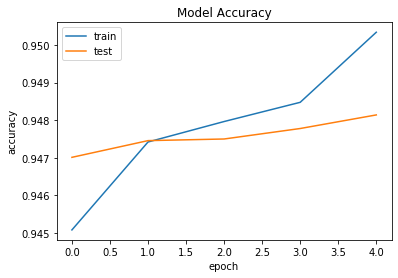

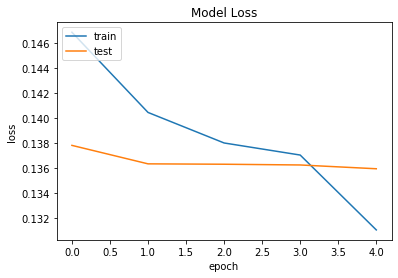

In [14]:
score = model_bidir.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_one_blstm.history.keys())
# summarize history for accuracy
plt.plot(history_one_blstm.history['acc'])
plt.plot(history_one_blstm.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_one_blstm.history['loss'])
plt.plot(history_one_blstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# Let's save the model to disc
json = model_bidir.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_minus5.json", "w") as file:
    file.write(json)
model_bidir.save_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_minus5.h5")
print("Saved model to disc")

Saved model to disc


In [15]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_minus5.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_minus5.h5")

In [17]:
y_preds_blstm_minus = model_avg_from_disc.predict(X_test, batch_size=1)

In [18]:
pred_avg = pd.DataFrame(y_preds_blstm_minus, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [19]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/BLSTM/AWGN/model_one_blstm_snr_minus5.csv', index = False)

In [6]:
yhat = model_avg_from_disc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.503823, G-Mean=0.948


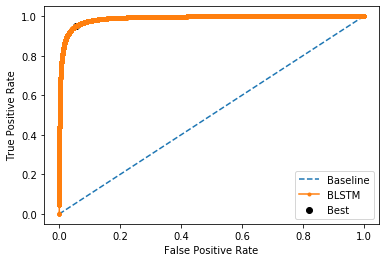

In [7]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='BLSTM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Matlab_awgn/BLSTM_ROC.png')
plt.show()

In [9]:
auc = roc_auc_score(y_test, yhat)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.989


In [16]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
preds_new = model_avg_from_disc.predict_classes(X_test)
metrics(preds_new, y_test)

F1-score:  0.9471515538187522
Precision:  0.9505629368763673
Recall:  0.9437645687645687
Acuracy:  0.9481391304347826
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    116744
           1       0.95      0.94      0.95    113256

    accuracy                           0.95    230000
   macro avg       0.95      0.95      0.95    230000
weighted avg       0.95      0.95      0.95    230000



## Checking best activation function

Train on 225000 samples, validate on 75000 samples
Epoch 1/5
225000/225000 [==============================] - 166s 737us/sample - loss: 0.6208 - acc: 0.6832 - val_loss: 0.6344 - val_acc: 0.7144
Epoch 2/5
225000/225000 [==============================] - 164s 731us/sample - loss: 0.5778 - acc: 0.7160 - val_loss: 0.5632 - val_acc: 0.7202
Epoch 3/5
225000/225000 [==============================] - 205s 910us/sample - loss: 0.5750 - acc: 0.7221 - val_loss: 0.5832 - val_acc: 0.7232
Epoch 4/5
225000/225000 [==============================] - 195s 869us/sample - loss: 0.5735 - acc: 0.7250 - val_loss: 0.5722 - val_acc: 0.7227
Epoch 5/5
225000/225000 [==============================] - 193s 859us/sample - loss: 0.5756 - acc: 0.7274 - val_loss: 0.5777 - val_acc: 0.7222
Train on 225000 samples, validate on 75000 samples
Epoch 1/5
225000/225000 [==============================] - 178s 793us/sample - loss: 0.5712 - acc: 0.7035 - val_loss: 0.5354 - val_acc: 0.7340
Epoch 2/5
225000/225000 [===============

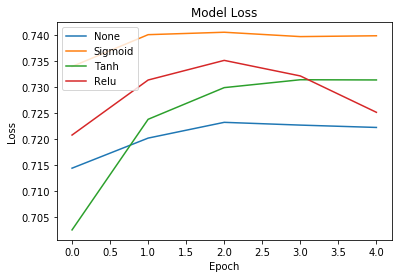

In [26]:
for activation in [None, 'sigmoid', 'tanh', 'relu']:
    model_bidir = Sequential()
    model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
    model_bidir.add(GlobalMaxPooling1D())
    model_bidir.add(Dense(16, activation=activation))
    model_bidir.add(Dropout(0.2))
    model_bidir.add(Dense(1, activation=activation))
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model_bidir.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=5,
                    validation_data=(X_test, y_test))
    
    plt.plot(history.history['val_acc'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['None', 'Sigmoid', 'Tanh', 'Relu'], loc='upper left')